## Building models which predict hunger

#### The models define hunger as the percent of a population undernourished.

This notebook creates models which predicts hunger using yield models which took into account  different temperature and climate conditions, both historic and projected. 

Projected data gathered from NASA and can be found here: https://www.nccs.nasa.gov/services/climate-data-services

In [1]:
#import 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for modeling 
from sklearn.linear_model import LinearRegression
from sklearn import metrics, linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from numpy import NaN
from sklearn.linear_model import LassoCV, RidgeCV,Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.stats import pearsonr
%matplotlib inline

In [2]:
df = pd.read_csv('data/thisisdf.csv')


df['pop-temp'] = (df['Population'] / df['AverageTemperature']) * df['AverageTemperature']

df['pop-precip'] = (df['Population'] / df['Average monthly precipitation']) * df['Average monthly precipitation']

In [179]:
no_mitigation_merged = pd.read_csv('data/Data2/no_mit_merged.csv')

no_mitigation_merged.head()

,Unnamed: 0,Year,reference,precip_reference,temp_no_mitigation,precip_no_mitigation,Country,cereals,potatoes,beans,...,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,log_pop,Precipitation Projected,Temperature Projected,temp_anoms
0,0,2000,0.52,0.02900,20.089,9.16500,Afghanistan,8063.0,167857.0,0.0,...,0.024,0.036932,16.917833,NaN,NaN,24.650437,16.849502,1.715942,15.828667,0.000000
1,190,2001,0.75,0.17944,20.319,9.31544,Afghanistan,10067.0,167857.0,0.0,...,0.024,0.018523,17.448083,0.618629,-0.237624,23.864507,16.888528,1.711865,15.926587,0.587525
2,349,2002,0.91,0.32988,20.479,9.46588,Afghanistan,16698.0,164286.0,0.0,...,0.024,0.015683,17.317667,0.614826,-0.238190,33.213400,16.933505,1.707787,16.024508,1.175050
3,507,2003,0.96,0.48032,20.529,9.61632,Afghanistan,14580.0,166667.0,0.0,...,0.024,0.045346,15.996000,0.611069,-0.238758,33.942645,16.980184,1.703710,16.122429,1.762574
4,665,2004,0.93,0.63076,20.499,9.76676,Afghanistan,13348.0,176471.0,0.0,...,0.024,-0.049689,17.530917,0.607358,-0.239330,29.385955,17.023406,1.699632,16.220350,2.350099


In [180]:
mitigation_merged = pd.read_csv('data/Data2/mit_merged.csv')

mitigation_merged.head()

,Unnamed: 0,Year,mitigation,temp_with_mitigation,precip_mitigation,precip_with_mitigation,Country,cereals,potatoes,beans,...,yield_percent_change,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,Precipitation Projected,Temperature Projected,temp_anoms
0,0,2000,0.52,20.089,0.02900,9.16500,Afghanistan,8063.0,167857.0,0.0,...,-0.012932,0.024,0.036932,16.917833,NaN,NaN,24.650437,1.715942,15.828667,0.000000
1,1,2001,0.75,20.319,0.18852,9.32452,Afghanistan,10067.0,167857.0,0.0,...,0.005477,0.024,0.018523,17.448083,0.146173,0.058824,23.864507,1.716951,15.851804,0.138824
2,2,2002,0.91,20.479,0.34804,9.48404,Afghanistan,16698.0,164286.0,0.0,...,0.008317,0.024,0.015683,17.317667,0.145960,0.058789,33.213400,1.717961,15.874941,0.277647
3,3,2003,0.74,20.309,0.50756,9.64356,Afghanistan,14580.0,166667.0,0.0,...,-0.021346,0.024,0.045346,15.996000,0.145747,0.058754,33.942645,1.718970,15.898078,0.416471
4,4,2003,0.74,20.309,0.50756,9.64356,Afghanistan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.145535,0.058720,NaN,1.719980,15.921216,0.555294


In [22]:
data = pd.read_csv('data/Data2/full_proj_df.csv')

## Run Lasso to test coefs

In [98]:
hunger

,Unnamed: 0,Unnamed: 0.1,index,Country,Code_x,Year,cereals,potatoes,beans,sugar,...,temp_anomalies,temp_pct_change,precip_change,precip_temp,pop-temp,pop-precip,Code_y,Undernourishment,pop-yield-temp,pop-yield
39,39,39,39,Afghanistan,AFG,2000,8063.0,167857.0,0.0,190000.0,...,16.917833,0.021685,-0.175624,24.650437,20780000.0,20780000.0,AFG,46.1,880.096679,56.788369
40,40,40,40,Afghanistan,AFG,2001,10067.0,167857.0,0.0,190000.0,...,17.448083,0.031343,-0.049079,23.864507,21607000.0,21607000.0,AFG,46.4,926.596380,58.726802
41,41,41,41,Afghanistan,AFG,2002,16698.0,164286.0,0.0,190000.0,...,17.317667,-0.007475,0.413284,33.213400,22601000.0,22601000.0,AFG,43.7,946.582075,60.921765
42,42,42,42,Afghanistan,AFG,2003,14580.0,166667.0,0.0,181818.0,...,15.996000,-0.076319,0.064549,33.942645,23681000.0,23681000.0,AFG,39.8,972.899608,65.225235
43,43,43,43,Afghanistan,AFG,2004,13348.0,176471.0,0.0,200000.0,...,17.530917,0.095956,-0.181178,29.385955,24727000.0,24727000.0,AFG,36.1,1000.380834,63.432003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7647,12648,12648,12383,Samoa,WSM,2009,0.0,0.0,0.0,120000.0,...,27.188333,0.009174,-0.020687,592.589430,185000.0,185000.0,WSM,3.5,20.112349,0.752473
7648,12649,12649,12384,Samoa,WSM,2010,0.0,0.0,0.0,120000.0,...,27.801667,0.022559,0.234317,743.301642,186000.0,186000.0,WSM,3.4,19.683364,0.724674
7649,12650,12650,12385,Samoa,WSM,2011,0.0,0.0,0.0,120000.0,...,26.925583,-0.031512,-0.114863,647.118213,187000.0,187000.0,WSM,3.3,20.393742,0.763365
7650,12651,12651,12386,Samoa,WSM,2012,0.0,0.0,0.0,120000.0,...,27.286667,0.013410,-0.140228,560.770297,189000.0,189000.0,WSM,3.1,21.460216,0.796987


In [109]:
features = [cols for cols in hunger._get_numeric_data().columns if cols != 'Undernourishment']

#feature = [col for col in df._get_numeric_data().columns if col != 'SalePrice']

X = hunger[features]

y = hunger['Undernourishment']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [111]:
l_alphas = np.logspace(-3,0,100)

# Cross-validate over our list of Lasso alphas.
lasso_model = LassoCV(alphas = l_alphas, cv = 5)

# Fit model using best ridge alpha!

lasso_model = lasso_model.fit(X_train, y_train)

In [113]:
coefs = pd.Series(lasso_model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs!= 0)) + " features and eliminated the other " +  \
str(sum(coefs == 0)) + " features")

Lasso picked 26 features and eliminated the other 5 features


Text(0.5, 1.0, 'Strong Coefficients in the Lasso Model')

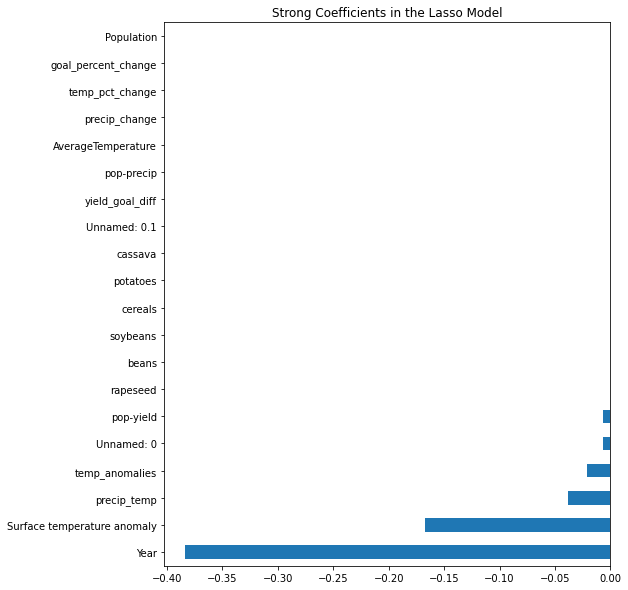

In [116]:
lasso_coefs = lasso_model.coef_

coef_lasso = pd.Series(lasso_model.coef_, index = X_train.columns)


important_coef_lasso = pd.concat([coef_lasso.sort_values().head(20)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
important_coef_lasso.plot(kind = "barh")
plt.title('Strong Coefficients in the Lasso Model')

In [119]:
important_coef_lasso.sort_values()

Year                          -3.834423e-01
Surface temperature anomaly   -1.671855e-01
precip_temp                   -3.812935e-02
temp_anomalies                -2.081221e-02
Unnamed: 0                    -7.049947e-03
pop-yield                     -6.973330e-03
rapeseed                      -3.722472e-04
beans                         -1.541223e-04
soybeans                      -1.264834e-04
cereals                       -7.844301e-05
potatoes                      -5.370265e-05
cassava                       -3.534486e-05
Unnamed: 0.1                  -2.836620e-16
yield_goal_diff               -6.556905e-17
pop-precip                     0.000000e+00
AverageTemperature             0.000000e+00
precip_change                 -0.000000e+00
temp_pct_change                0.000000e+00
goal_percent_change           -0.000000e+00
Population                     3.062337e-09
dtype: float64

## Predicting Hunger based on yields using past Data 

In [25]:
undernourished = pd.read_csv('data/Data2/prevalence-of-undernourishment.csv')

undernourished.head()

undernourished.rename(columns = {"Entity": 'Country',
                                'Suite of Food Security Indicators - Prevalence of undernourishment (percent) (3-year average) - 210041 - Value - 6121 - %': 'Undernourishment'}, inplace = True)

In [26]:
hunger = pd.merge(df, undernourished, how = 'left', right_on = ['Country', 'Year'], left_on = ['Country', 'Year'])

hunger.shape

(7708, 34)

In [28]:
hunger.dropna(inplace = True)

hunger.head()

,Unnamed: 0,Unnamed: 0.1,index,Country,Code_x,Year,cereals,potatoes,beans,sugar,...,yield_goal_diff,country_cat,temp_anomalies,temp_pct_change,precip_change,precip_temp,pop-temp,pop-precip,Code_y,Undernourishment
39,39,39,39,Afghanistan,AFG,2000,8063.0,167857.0,0.0,190000.0,...,0.036932,0,16.917833,0.021685,-0.175624,24.650437,20780000.0,20780000.0,AFG,46.1
40,40,40,40,Afghanistan,AFG,2001,10067.0,167857.0,0.0,190000.0,...,0.018523,0,17.448083,0.031343,-0.049079,23.864507,21607000.0,21607000.0,AFG,46.4
41,41,41,41,Afghanistan,AFG,2002,16698.0,164286.0,0.0,190000.0,...,0.015683,0,17.317667,-0.007475,0.413284,33.213400,22601000.0,22601000.0,AFG,43.7
42,42,42,42,Afghanistan,AFG,2003,14580.0,166667.0,0.0,181818.0,...,0.045346,0,15.996000,-0.076319,0.064549,33.942645,23681000.0,23681000.0,AFG,39.8
43,43,43,43,Afghanistan,AFG,2004,13348.0,176471.0,0.0,200000.0,...,-0.049689,0,17.530917,0.095956,-0.181178,29.385955,24727000.0,24727000.0,AFG,36.1


In [30]:
#Feature engineering hunger data 

hunger['pop-yield-temp'] = (hunger['Population'] / hunger['total_yield']) * hunger['AverageTemperature']

hunger['pop-yield'] = hunger['Population'] / hunger['total_yield']

## Basic hunger model

In [155]:
hunger.head()

,Unnamed: 0,Unnamed: 0.1,index,Country,Code_x,Year,cereals,potatoes,beans,sugar,...,temp_anomalies,temp_pct_change,precip_change,precip_temp,pop-temp,pop-precip,Code_y,Undernourishment,pop-yield-temp,pop-yield
39,39,39,39,Afghanistan,AFG,2000,8063.0,167857.0,0.0,190000.0,...,16.917833,0.021685,-0.175624,24.650437,20780000.0,20780000.0,AFG,46.1,880.096679,56.788369
40,40,40,40,Afghanistan,AFG,2001,10067.0,167857.0,0.0,190000.0,...,17.448083,0.031343,-0.049079,23.864507,21607000.0,21607000.0,AFG,46.4,926.596380,58.726802
41,41,41,41,Afghanistan,AFG,2002,16698.0,164286.0,0.0,190000.0,...,17.317667,-0.007475,0.413284,33.213400,22601000.0,22601000.0,AFG,43.7,946.582075,60.921765
42,42,42,42,Afghanistan,AFG,2003,14580.0,166667.0,0.0,181818.0,...,15.996000,-0.076319,0.064549,33.942645,23681000.0,23681000.0,AFG,39.8,972.899608,65.225235
43,43,43,43,Afghanistan,AFG,2004,13348.0,176471.0,0.0,200000.0,...,17.530917,0.095956,-0.181178,29.385955,24727000.0,24727000.0,AFG,36.1,1000.380834,63.432003


In [156]:
#hunger_features = hunger[['Country','Year', 'AverageTemperature','temp_anomalies', 'temp_pct_change','Average monthly precipitation', 'Undernourishment']]
hunger_features = hunger[['Country','Year', 'total_yield']]
hunger_label = hunger['Undernourishment']

#One hot Encode my features 

hunger_df_onehot = pd.get_dummies(hunger_features, columns=['Country', 'Year'], prefix = ['Country', 'Year'])

hunger_features=hunger_df_onehot.loc[:, hunger_df_onehot.columns != 'Undernourishment']

hunger_features.head()

,total_yield,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,Country_Azerbaijan,Country_Bangladesh,Country_Belarus,...,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013
39,365920,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,367924,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,370984,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,363065,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,389819,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [161]:
#Scale features 
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

hunger_features=scaler.fit_transform(hunger_features)

#Train test split 

hunger_train_data, hunger_test_data, hunger_train_labels, hunger_test_labels = train_test_split(hunger_features, hunger_label, test_size=0.35, random_state=42)

In [162]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

models = [
    GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0),
     RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0),
    svm.SVR(),
   DecisionTreeRegressor()
]

In [163]:
from sklearn.metrics import r2_score
def compare_models(model):
    model_name = model.__class__.__name__
    fit=model.fit(hunger_train_data,hunger_train_labels)
    y_pred=fit.predict(hunger_test_data)
    r2=r2_score(hunger_test_labels,y_pred)
    return([model_name,r2])

In [164]:
#Compare and score different models 

model_train=list(map(compare_models,models))

print(*model_train, sep = "\n")

['GradientBoostingRegressor', 0.8360408494364657]
['RandomForestRegressor', 0.29158404443443464]
['SVR', 0.14197620119670984]
['DecisionTreeRegressor', 0.8858757775934064]


In [166]:
hunger_df_onehot.head()

,total_yield,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,Country_Azerbaijan,Country_Bangladesh,Country_Belarus,...,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013
39,365920,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,367924,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,370984,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,363065,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,389819,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [167]:
#setting test data to columns from dataframe and excluding 'hg/ha_yield' values where ML model should be predicting 

hunger_test_df=pd.DataFrame(hunger_test_data,columns=hunger_df_onehot.loc[:, hunger_df_onehot.columns != 'Undernourishment'].columns) 

# using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe

cntry=hunger_test_df[[col for col in hunger_test_df.columns if 'Country' in col]].stack()[hunger_test_df[[col for col in hunger_test_df.columns if 'Country' in col]].stack()>0]
cntrylist=list(pd.DataFrame(cntry).index.get_level_values(1))
countries=[i.split("_")[1] for i in cntrylist]

hunger_test_df.head()

,total_yield,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,Country_Azerbaijan,Country_Bangladesh,Country_Belarus,...,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013
0,0.387927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.123772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.036943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.827450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.569928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
yr= hunger_test_df[[col for col in hunger_test_df.columns if 'Year' in col]].stack()[hunger_test_df[[col for col in hunger_test_df.columns if 'Year' in col]].stack()>0]
yrlist=list(pd.DataFrame(yr).index.get_level_values(1))
yrs=[i.split("_")[1] for i in yrlist]

In [169]:
hunger_test_df.drop([col for col in hunger_test_df.columns if 'Country' in col],axis=1,inplace=True)
hunger_test_df.head()



hunger_test_df.drop([col for col in hunger_test_df.columns if 'Year' in col],axis=1,inplace=True)
hunger_test_df.head()


,total_yield
0,0.387927
1,0.123772
2,0.036943
3,0.827450
4,0.569928


In [170]:
hunger_test_df['Country']=countries
hunger_test_df['Year'] = yrs

In [172]:
tree=GradientBoostingRegressor()
hunger_model=tree.fit(hunger_train_data,hunger_train_labels)

hunger_test_df["hunger_predicted"]= hunger_model.predict(hunger_test_data)
hunger_test_df["hunger_actual"]=pd.DataFrame(hunger_test_labels)["Undernourishment"].tolist()
hunger_test_group=hunger_test_df.groupby("Country")
hunger_test_group.apply(lambda x: r2_score(x.hunger_actual,x.hunger_predicted))

Country
Afghanistan           NaN
Albania        -37.507659
Algeria         -0.740766
Angola          -0.389622
Argentina     -289.489464
                  ...    
Venezuela       -2.934567
Vietnam         -0.438580
Yemen          -37.958267
Zambia          -6.588438
Zimbabwe       -26.070346
Length: 107, dtype: float64

In [173]:
import pickle 
pickle_out = open("hunger3.pkl", mode = "wb") 
pickle.dump(hunger_model, pickle_out) 
pickle_out.close()

In [144]:
#Look at predicted vs. Actual, accuracy ~ 88%

hunger_test_df

,total_yield,Country,Year,hunger_predicted,hunger_actual
5251,721547,Pakistan,2005,14.848249,23.3
1839,231256,Cyprus,2010,9.937305,4.3
4322,70094,Mauritania,2007,17.543880,10.2
2148,1537334,Egypt,2000,15.141878,5.2
967,1059354,Burkina Faso,2000,16.089420,25.4
...,...,...,...,...,...
2822,1514243,Guatemala,2005,14.848249,15.8
4566,890199,Morocco,2009,14.848249,5.4
1334,1189265,Chad,2004,31.800406,39.1
1643,690020,Congo,2004,34.070877,36.7


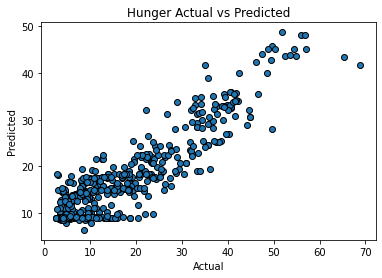

In [51]:
fig, ax = plt.subplots() 

ax.scatter(hunger_test_df["hunger_actual"], hunger_test_df["hunger_predicted"],edgecolors=(0, 0, 0))

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Hunger Actual vs Predicted")
plt.show()

# Predicting Hunger based on Yields on future yield Mitigation data

these models were built using a comabination of predicted yield data from past models and projected climate conditions which NASA used. 

NASA data can be found here:  https://www.nccs.nasa.gov/services/climate-data-services

In [55]:
#Grabbing certain years so that the number of model features will match created model. 

years_needed = ['2000','2005','2012','2020', '2030', '2040','2046', '2050','2056','2060', '2066', '2076', '2086', '2096', '2100']



In [58]:
mitigation_merged['Year'] = mitigation_merged['Year'].astype('int')

mitigation_merged.head()

,Year,mitigation,temp_with_mitigation,precip_mitigation,precip_with_mitigation,Country,cereals,potatoes,beans,sugar,...,yield_percent_change,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,Precipitation Projected,Temperature Projected,temp_anoms
0,2000,0.52,20.089,0.02900,9.16500,Afghanistan,8063.0,167857.0,0.0,190000.0,...,-0.012932,0.024,0.036932,16.917833,NaN,NaN,24.650437,1.715942,15.828667,0.000000
1,2001,0.75,20.319,0.18852,9.32452,Afghanistan,10067.0,167857.0,0.0,190000.0,...,0.005477,0.024,0.018523,17.448083,0.146173,0.058824,23.864507,1.716951,15.851804,0.138824
2,2002,0.91,20.479,0.34804,9.48404,Afghanistan,16698.0,164286.0,0.0,190000.0,...,0.008317,0.024,0.015683,17.317667,0.145960,0.058789,33.213400,1.717961,15.874941,0.277647
3,2003,0.74,20.309,0.50756,9.64356,Afghanistan,14580.0,166667.0,0.0,181818.0,...,-0.021346,0.024,0.045346,15.996000,0.145747,0.058754,33.942645,1.718970,15.898078,0.416471
4,2003,0.74,20.309,0.50756,9.64356,Afghanistan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.145535,0.058720,NaN,1.719980,15.921216,0.555294


### Projected data includes more years and countries than original data model was built on. 

Will have to the same number of years and the same countries to make accurate predictions

In [59]:
#Grabbing data by years needed. 

years_needed_df = mitigation_merged[np.isin(mitigation_merged, [2000,2005,2012,2020, 2030,2040,
                                                                2050,2056,2060,2066,2076,2086, 2096, 2100]).any(axis=1)]

In [61]:
mitigation_merged['Year'] = mitigation_merged['Year'].astype('object')

years_needed_df.head()

,Year,mitigation,temp_with_mitigation,precip_mitigation,precip_with_mitigation,Country,cereals,potatoes,beans,sugar,...,yield_percent_change,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,Precipitation Projected,Temperature Projected,temp_anoms
0,2000,0.52,20.089,0.02900,9.16500,Afghanistan,8063.0,167857.0,0.0,190000.0,...,-0.012932,0.024,0.036932,16.917833,NaN,NaN,24.650437,1.715942,15.828667,0.000000
6,2005,0.89,20.459,0.82660,9.96260,Afghanistan,17904.0,150000.0,0.0,190000.0,...,-0.081871,0.024,0.105871,15.890000,0.145113,0.058651,31.321226,1.721998,15.967490,0.832941
13,2012,1.16,20.729,1.94324,11.07924,Afghanistan,20296.0,109524.0,0.0,250000.0,...,-0.088284,0.024,0.112284,15.141583,0.143653,0.058411,30.830318,1.729064,16.129451,1.804706
22,2020,1.45,21.019,3.21940,12.35540,Afghanistan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.141820,0.058106,NaN,1.738148,16.337686,3.054118
32,2030,1.79,21.359,4.25940,13.39540,Afghanistan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.139837,0.057770,NaN,1.748242,16.569059,4.442353


In [62]:
#Grabbing data now based on countries needed.

countries_needed = years_needed_df[np.isin(years_needed_df, ['Pakistan', 'Cyprus', 'Mauritania', 'Egypt', 'Burkina Faso',
       'Bulgaria', 'Congo', 'Angola', 'Fiji', 'Central African Republic',
       'Rwanda', 'Mali', 'Lebanon', 'Honduras', 'North Korea',
       'Kazakhstan', 'Sierra Leone', 'Argentina', 'Russia', 'Philippines',
       'Mongolia', 'Croatia', 'Taiwan','Japan', 'Ukraine', 'Latvia', 'Sudan','Chad', 'Venezuela', 'Zimbabwe',
       'Nepal', 'Colombia', 'Nigeria', 'Vietnam', 'Panama', 'Slovakia',
       'Chile', 'Mauritius', 'Lesotho', 'Algeria', 'Cape Verde',
       'Paraguay', 'Sri Lanka', 'Mexico', 'India', 'Ethiopia', 'Uruguay',
       'Morocco', 'Belize', 'Kenya', 'Armenia', 'Senegal', 'Madagascar',
       'Jordan', 'Cameroon', 'Jamaica', 'Ecuador', 'China', 'Uzbekistan',
       'Indonesia', 'Cambodia', 'Djibouti', 'Ghana', 'Haiti', 'Brazil',
       'Albania', 'Zambia', 'Yemen', 'Botswana', 'Kyrgyzstan', 'Malaysia',
       'Gabon', 'Costa Rica', 'Laos', 'Saudi Arabia', 'Turkmenistan',
       'Niger', 'Peru', 'Bolivia', 'Liberia', 'Bangladesh',
       'United Arab Emirates', 'Oman', 'Namibia', 'Uganda', 'Samoa',
       'Solomon Islands', 'South Africa', 'Suriname', 'Georgia',
       'Mozambique', 'Guyana', 'Malawi', 'Tanzania', 'Togo', 'Guatemala',
       'Dominican Republic', 'Iran', 'Benin', 'Belarus', 'Nicaragua',
       'Tunisia', 'Guinea', 'Cuba', 'Azerbaijan', 'Thailand', 'Serbia',
       'Gambia', 'El Salvador', 'Afghanistan', 'Estonia'])]

In [63]:
countries_needed

,Year,mitigation,temp_with_mitigation,precip_mitigation,precip_with_mitigation,Country,cereals,potatoes,beans,sugar,...,yield_percent_change,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,Precipitation Projected,Temperature Projected,temp_anoms
0,2000,0.52,20.089,0.02900,9.16500,Afghanistan,8063.0,167857.0,0.0,190000.0,...,-0.012932,0.024,0.036932,16.917833,NaN,NaN,24.650437,1.715942,15.828667,0.000000
6,2005,0.89,20.459,0.82660,9.96260,Afghanistan,17904.0,150000.0,0.0,190000.0,...,-0.081871,0.024,0.105871,15.890000,0.145113,0.058651,31.321226,1.721998,15.967490,0.832941
13,2012,1.16,20.729,1.94324,11.07924,Afghanistan,20296.0,109524.0,0.0,250000.0,...,-0.088284,0.024,0.112284,15.141583,0.143653,0.058411,30.830318,1.729064,16.129451,1.804706
22,2020,1.45,21.019,3.21940,12.35540,Afghanistan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.141820,0.058106,NaN,1.738148,16.337686,3.054118
32,2030,1.79,21.359,4.25940,13.39540,Afghanistan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.139837,0.057770,NaN,1.748242,16.569059,4.442353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16394,2066,2.10,21.669,5.78004,14.91604,Zimbabwe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.098304,0.056593,NaN,5.306433,23.559583,9.440000
16404,2076,1.95,21.519,6.10800,15.24400,Zimbabwe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.097347,0.056275,NaN,5.336447,23.790956,10.828235
16414,2086,2.34,21.909,6.28800,15.42400,Zimbabwe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.096408,0.055960,NaN,5.366461,24.022328,12.216471
16424,2096,2.46,22.029,6.46800,15.60400,Zimbabwe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.095488,0.055648,NaN,5.396474,24.253701,13.604706


In [64]:
#defining my features

mitigation_yields = countries_needed[['Country','Year', 'Temperature Projected','temp_anoms',
                                      'temp_pct_change','Precipitation Projected']]

In [65]:
#One hot Encode my features 

mit_hunger_df_onehot = pd.get_dummies(mitigation_yields, columns=['Country', 'Year'], prefix = ['Country', 'Year'])

mit_hunger_features= mit_hunger_df_onehot.loc[:, mit_hunger_df_onehot.columns != 'Undernourishment']

mit_hunger_features.head()

,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,...,Year_2030,Year_2040,Year_2050,Year_2056,Year_2060,Year_2066,Year_2076,Year_2086,Year_2096,Year_2100
0,15.828667,0.000000,NaN,1.715942,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,15.967490,0.832941,0.145113,1.721998,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,16.129451,1.804706,0.143653,1.729064,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,16.337686,3.054118,0.141820,1.738148,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,16.569059,4.442353,0.139837,1.748242,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [66]:
#scale features 
scaler=MinMaxScaler()
mit_hunger_features=scaler.fit_transform(mit_hunger_features)
mit_hunger_features

In [67]:
mit_hunger_test_df=pd.DataFrame(mit_hunger_features, columns= mit_hunger_df_onehot.loc[:, mit_hunger_df_onehot.columns != 'Undernourishment'].columns) 

# using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe

cntry=mit_hunger_test_df[[col for col in mit_hunger_test_df.columns if 'Country' in col]].stack()[mit_hunger_test_df[[col for col in mit_hunger_test_df.columns if 'Country' in col]].stack()>0]
cntrylist=list(pd.DataFrame(cntry).index.get_level_values(1))
countries=[i.split("_")[1] for i in cntrylist]

mit_hunger_test_df.head()

,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,...,Year_2030,Year_2040,Year_2050,Year_2056,Year_2060,Year_2066,Year_2076,Year_2086,Year_2096,Year_2100
0,15.828667,0.000000,NaN,1.715942,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,15.967490,0.832941,0.145113,1.721998,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,16.129451,1.804706,0.143653,1.729064,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,16.337686,3.054118,0.141820,1.738148,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,16.569059,4.442353,0.139837,1.748242,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [68]:
#Fill nulls creatures by feature engineering 

mit_hunger_test_df.fillna(0, inplace = True)

In [69]:
#Grab Years

yr= mit_hunger_test_df[[col for col in mit_hunger_test_df.columns if 'Year' in col]].stack()[mit_hunger_test_df[[col for col in mit_hunger_test_df.columns if 'Year' in col]].stack()>0]
yrlist=list(pd.DataFrame(yr).index.get_level_values(1))
yrs=[i.split("_")[1] for i in yrlist]

mit_hunger_test_df.drop([col for col in mit_hunger_test_df.columns if 'Country' in col],axis=1,inplace=True)
mit_hunger_test_df.head()



mit_hunger_test_df.drop([col for col in mit_hunger_test_df.columns if 'Year' in col],axis=1,inplace=True)
mit_hunger_test_df.head()


,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected
0,15.828667,0.000000,0.000000,1.715942
6,15.967490,0.832941,0.145113,1.721998
13,16.129451,1.804706,0.143653,1.729064
22,16.337686,3.054118,0.141820,1.738148
32,16.569059,4.442353,0.139837,1.748242


In [70]:
#put years and countries back into the test dataframe 

mit_hunger_test_df['Country']=countries
mit_hunger_test_df['Year'] = yrs

#Make predcitions using model created above 
mit_hunger_test_df["hunger_predicted"]= hunger_model.predict(mit_hunger_features)

mit_hunger_test_group=mit_hunger_test_df.groupby("Country")

mit_hunger_test_df

,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected,Country,Year,hunger_predicted
0,15.828667,0.000000,0.000000,1.715942,Afghanistan,2000,33.030351
6,15.967490,0.832941,0.145113,1.721998,Afghanistan,2005,32.150042
13,16.129451,1.804706,0.143653,1.729064,Afghanistan,2012,29.710355
22,16.337686,3.054118,0.141820,1.738148,Afghanistan,2020,28.180355
32,16.569059,4.442353,0.139837,1.748242,Afghanistan,2030,28.180355
...,...,...,...,...,...,...,...
16394,23.559583,9.440000,0.098304,5.306433,Zimbabwe,2066,35.648197
16404,23.790956,10.828235,0.097347,5.336447,Zimbabwe,2076,35.648197
16414,24.022328,12.216471,0.096408,5.366461,Zimbabwe,2086,33.238742
16424,24.253701,13.604706,0.095488,5.396474,Zimbabwe,2096,33.238742


## Predicting Hunger based on Yields on future yield no- mitigation data

Repeating the same steps I took for the mitigation data

In [73]:
#grabbing years 

needed_df = no_mitigation_merged[np.isin(no_mitigation_merged, [2000,2005,2012,2020, 2030,2040,
                                                                2050,2056,2060,2066,2076,2086, 2096, 2100]).any(axis=1)]

In [74]:
needed_df['Year'] = needed_df['Year'].astype('category')

In [75]:
#grabbing countries 

countries_need = needed_df[np.isin(needed_df, ['Pakistan', 'Cyprus', 'Mauritania', 'Egypt', 'Burkina Faso',
       'Bulgaria', 'Congo', 'Angola', 'Fiji', 'Central African Republic',
       'Rwanda', 'Mali', 'Lebanon', 'Honduras', 'North Korea',
       'Kazakhstan', 'Sierra Leone', 'Argentina', 'Russia', 'Philippines',
       'Mongolia', 'Croatia', 'Taiwan','Japan', 'Ukraine', 'Latvia', 'Sudan','Chad', 'Venezuela', 'Zimbabwe',
       'Nepal', 'Colombia', 'Nigeria', 'Vietnam', 'Panama', 'Slovakia',
       'Chile', 'Mauritius', 'Lesotho', 'Algeria', 'Cape Verde',
       'Paraguay', 'Sri Lanka', 'Mexico', 'India', 'Ethiopia', 'Uruguay',
       'Morocco', 'Belize', 'Kenya', 'Armenia', 'Senegal', 'Madagascar',
       'Jordan', 'Cameroon', 'Jamaica', 'Ecuador', 'China', 'Uzbekistan',
       'Indonesia', 'Cambodia', 'Djibouti', 'Ghana', 'Haiti', 'Brazil',
       'Albania', 'Zambia', 'Yemen', 'Botswana', 'Kyrgyzstan', 'Malaysia',
       'Gabon', 'Costa Rica', 'Laos', 'Saudi Arabia', 'Turkmenistan',
       'Niger', 'Peru', 'Bolivia', 'Liberia', 'Bangladesh',
       'United Arab Emirates', 'Oman', 'Namibia', 'Uganda', 'Samoa',
       'Solomon Islands', 'South Africa', 'Suriname', 'Georgia',
       'Mozambique', 'Guyana', 'Malawi', 'Tanzania', 'Togo', 'Guatemala',
       'Dominican Republic', 'Iran', 'Benin', 'Belarus', 'Nicaragua',
       'Tunisia', 'Guinea', 'Cuba', 'Azerbaijan', 'Thailand', 'Serbia',
       'Gambia', 'El Salvador', 'Afghanistan', 'Estonia'])]

In [77]:
#Instantiating features needed

no_mitigation_yields = countries_need[['Country','Year', 'Temperature Projected','temp_anoms',
                                       'temp_pct_change','Precipitation Projected']]

no_mitigation_yields

,Country,Year,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected
0,Afghanistan,2000,15.828667,0.000000,NaN,1.715942
823,Afghanistan,2005,16.318271,2.937624,0.603691,1.695555
1941,Afghanistan,2012,17.003716,7.050297,0.579214,1.667012
3376,Afghanistan,2020,17.885003,12.338020,0.550516,1.630315
4966,Afghanistan,2030,18.864211,18.213267,0.521791,1.589540
...,...,...,...,...,...,...
10848,Zimbabwe,2066,28.546943,39.364158,0.344197,4.290007
12438,Zimbabwe,2076,29.526151,45.239406,0.332744,4.168763
14028,Zimbabwe,2086,30.505359,51.114653,0.322029,4.047519
15618,Zimbabwe,2096,31.484567,56.989901,0.311982,3.926276


In [79]:
#One hot Encode my features 

no_mit_hunger_df_onehot = pd.get_dummies(no_mitigation_yields, columns=['Country', 'Year'], prefix = ['Country', 'Year'])

no_mit_hunger_features= no_mit_hunger_df_onehot.loc[:, no_mit_hunger_df_onehot.columns != 'Undernourishment']
no_mit_hunger_features.fillna(0, inplace = True)
no_mit_hunger_features.head()

,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,...,Year_2030,Year_2040,Year_2050,Year_2056,Year_2060,Year_2066,Year_2076,Year_2086,Year_2096,Year_2100
0,15.828667,0.000000,0.000000,1.715942,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
823,16.318271,2.937624,0.603691,1.695555,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1941,17.003716,7.050297,0.579214,1.667012,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3376,17.885003,12.338020,0.550516,1.630315,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4966,18.864211,18.213267,0.521791,1.589540,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [80]:
#scale my features 
scaler=MinMaxScaler()
no_mit_hunger_features=scaler.fit_transform(no_mit_hunger_features)
no_mit_hunger_features

In [81]:
no_mit_hunger_test_df=pd.DataFrame(no_mit_hunger_features, columns= no_mit_hunger_df_onehot.loc[:, no_mit_hunger_df_onehot.columns != 'Undernourishment %'].columns) 

# using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe

cntry=no_mit_hunger_test_df[[col for col in no_mit_hunger_test_df.columns if 'Country' in col]].stack()[no_mit_hunger_test_df[[col for col in no_mit_hunger_test_df.columns if 'Country' in col]].stack()>0]
cntrylist=list(pd.DataFrame(cntry).index.get_level_values(1))
countries=[i.split("_")[1] for i in cntrylist]

no_mit_hunger_test_df

,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,...,Year_2030,Year_2040,Year_2050,Year_2056,Year_2060,Year_2066,Year_2076,Year_2086,Year_2096,Year_2100
0,15.828667,0.000000,0.000000,1.715942,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
823,16.318271,2.937624,0.603691,1.695555,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1941,17.003716,7.050297,0.579214,1.667012,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3376,17.885003,12.338020,0.550516,1.630315,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4966,18.864211,18.213267,0.521791,1.589540,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10848,28.546943,39.364158,0.344197,4.290007,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12438,29.526151,45.239406,0.332744,4.168763,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14028,30.505359,51.114653,0.322029,4.047519,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15618,31.484567,56.989901,0.311982,3.926276,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [82]:
#grabbing years 
yr= no_mit_hunger_test_df[[col for col in no_mit_hunger_test_df.columns if 'Year' in col]].stack()[no_mit_hunger_test_df[[col for col in no_mit_hunger_test_df.columns if 'Year' in col]].stack()>0]
yrlist=list(pd.DataFrame(yr).index.get_level_values(1))
yrs=[i.split("_")[1] for i in yrlist]

no_mit_hunger_test_df.drop([col for col in no_mit_hunger_test_df.columns if 'Country' in col],axis=1,inplace=True)
no_mit_hunger_test_df.head()



no_mit_hunger_test_df.drop([col for col in no_mit_hunger_test_df.columns if 'Year' in col],axis=1,inplace=True)
no_mit_hunger_test_df.head()

,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected
0,15.828667,0.000000,0.000000,1.715942
823,16.318271,2.937624,0.603691,1.695555
1941,17.003716,7.050297,0.579214,1.667012
3376,17.885003,12.338020,0.550516,1.630315
4966,18.864211,18.213267,0.521791,1.589540


In [83]:
no_mit_hunger_features

,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,...,Year_2030,Year_2040,Year_2050,Year_2056,Year_2060,Year_2066,Year_2076,Year_2086,Year_2096,Year_2100
0,15.828667,0.000000,0.000000,1.715942,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
823,16.318271,2.937624,0.603691,1.695555,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1941,17.003716,7.050297,0.579214,1.667012,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3376,17.885003,12.338020,0.550516,1.630315,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4966,18.864211,18.213267,0.521791,1.589540,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10848,28.546943,39.364158,0.344197,4.290007,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12438,29.526151,45.239406,0.332744,4.168763,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14028,30.505359,51.114653,0.322029,4.047519,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15618,31.484567,56.989901,0.311982,3.926276,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [84]:
no_mit_hunger_test_df.fillna(0,inplace = True)
no_mit_hunger_test_df.head()

,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected
0,15.828667,0.000000,0.000000,1.715942
823,16.318271,2.937624,0.603691,1.695555
1941,17.003716,7.050297,0.579214,1.667012
3376,17.885003,12.338020,0.550516,1.630315
4966,18.864211,18.213267,0.521791,1.589540


In [85]:
#Putting countries and years back into dataframe with predictions 
no_mit_hunger_test_df['Country']=countries
no_mit_hunger_test_df['Year'] = yrs

no_mit_hunger_test_df["hunger_predicted"]= hunger_model.predict(no_mit_hunger_features)

no_mit_hunger_test_group=mit_hunger_test_df.groupby("Country")

no_mit_hunger_test_df

,Temperature Projected,temp_anoms,temp_pct_change,Precipitation Projected,Country,Year,hunger_predicted
0,15.828667,0.000000,0.000000,1.715942,Afghanistan,2000,33.030351
823,16.318271,2.937624,0.603691,1.695555,Afghanistan,2005,32.150042
1941,17.003716,7.050297,0.579214,1.667012,Afghanistan,2012,32.120042
3376,17.885003,12.338020,0.550516,1.630315,Afghanistan,2020,32.120042
4966,18.864211,18.213267,0.521791,1.589540,Afghanistan,2030,32.120042
...,...,...,...,...,...,...,...
10848,28.546943,39.364158,0.344197,4.290007,Zimbabwe,2066,31.186686
12438,29.526151,45.239406,0.332744,4.168763,Zimbabwe,2076,31.186686
14028,30.505359,51.114653,0.322029,4.047519,Zimbabwe,2086,31.186686
15618,31.484567,56.989901,0.311982,3.926276,Zimbabwe,2096,31.186686


#### These models were then put into a .py file and used to generate predictions on a  created website.

The yield data used in these models can be found in my modeling yield data file. 